# Results


In [168]:
import requests
import numpy as np
import plots as pl
import pandas as pd
import matplotlib.pyplot as plt 
import aplpy 
import os
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from IPython.core.display import HTML
display(HTML("<style>.container { width:200% !important; }</style>"))

from astropy.coordinates import ICRS, Galactic, FK4, FK5
from astropy import units as u
from astropy.coordinates import SkyCoord

import glob
import json

import datetime

import math

In [169]:
def query(ra, dec, radius=5):
    url = f"http://simbad.u-strasbg.fr/simbad/sim-coo?Coord={ra}d{dec}d&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius={radius}&Radius.unit=arcmin&submit=submit+query"
    return url

In [170]:
def get_response(ra, dec, radius=5):
    url = query(ra, dec, radius)
    response = requests.get(url)
    tables = pd.read_html(response.text)
    idx = np.argmax(['Identifier' in t.columns for t in tables])
    table = tables[idx]
    try:
        identifier = table.loc[0, 'Identifier']
    except KeyError:
        identifier = 'No object found'
    return identifier, url, table

In [171]:
# Generic function for plotting light-curves and stats.
def plot_lc(source):
  exists = os.path.isfile('thumbs/'+str(source)+'_Avg_LC.jpg')
  if not exists: 
    all = filtered_raw_data[filtered_raw_data.source_id == source]
    all = all.sort_values(by='jd')
    plt.figure(figsize=(7, 8))
    plt.subplot(2,1,1)
    f = list(all.raw_peak_flux)
    s_stats = stats[stats.source_id == source]
    plt.title(str(source)+' RA='+str(round(s_stats.ra.values[0], 3))+' DEC='+str(round(s_stats.dec.values[0], 3)))
    #plt.title(str(source)+' RA='+str(s_stats.ra)+' DEC='+str(s_stats.dec))
    plt.plot(list(f), 'k.', label='Flux')
    plt.xlabel('Observation Number')
    plt.ylabel('Flux (Jy)')
    # Non-averaged
    plt.subplot(2,1,2)
    plt.plot(all.jd, all.raw_peak_flux, 'k.', label='Flux')
    ts = []
    ys = []
    for t in all.jd:
        sli = stats[stats.source_id == source]
        y = (sli.grad * t) + sli.y_int
        ts.append(float(t))
        ys.append(float(y))
    plt.plot(ts,ys,'k-.', label='$\\nabla_{S} = $'+str( round(float(sli.sig),2) ))
        
    # Averaged 
    avg = filtered_raw_avg_data[filtered_raw_avg_data.source_id == source]
    plt.errorbar(avg.mean_jd, avg.median_flux, avg.std_flux, fmt='ro', label="Median flux", markersize=10)
    ts = []
    ys = []
    for t in avg.mean_jd:
        sli = stats[stats.source_id == source]
        y = (sli.avg_grad * t) + sli.avg_y_int
        ts.append(float(t))
        ys.append(float(y))
    plt.plot(ts,ys,'r-.', label='Median $\\nabla_{S} = $'+str( round(float(sli.avg_sig),2) ))
    #plt.ylim(np.mean(f)*0.8, np.mean(f)*1.2)
    plt.xlabel('Time (JD)')
    plt.ylabel('Flux (Jy)')
    plt.savefig('thumbs/'+str(source)+'_Avg_LC.jpg')
    plt.legend()
    plt.close

In [172]:
def get_image(source_id):
    exists = os.path.isfile('thumbs/'+str(source_id)+'.jpg')
    if not exists:
        # Select random image
        plt.figure(figsize=[10,12])
        image = filtered_raw_data[filtered_raw_data.source_id == source_id].image.sample(1).values[0]
        s_stats = stats[stats.source_id == source_id]
        grid = True
        size=(500, 500)
        dpi = 40
        figure = aplpy.FITSFigure('/Volumes/BEL27A-BKP01/MWATS/'+image, dimensions=[0,1], slices=[0,0], auto_refresh=False, dpi = dpi, figsize = (size[0] / float(dpi), size[1] / float(dpi)))
        ra = s_stats.ra.values[0]
        dec = s_stats.dec.values[0]
        circle_size = 1.0 # 1 degree circle
        figure.recenter(ra, dec, radius=1.0, width=2.0, height=2.0)
        #figure.recenter(ra, dec, circle_size) 
        if grid:
            try:
                figure.add_grid()
            except Exception as e:
                logging.warn("APLpy error adding grid to image: {0}".format(e))
        # Adjust the axis labels, otherwise they overlap
        # If the image is less than two arc minutes across, show seconds on the tick labels
    
        image_radius = circle_size
        if image_radius < 1.0 / 60.0 * 2:
                figure.tick_labels.set_xformat("hh:mm:ss")
                figure.tick_labels.set_yformat("dd:mm:ss")
        else:
                figure.tick_labels.set_xformat("hh:mm")
                figure.tick_labels.set_yformat("dd:mm")

        figure.tick_labels.set_xformat("dd:mm")
        figure.tick_labels.set_yformat("dd:mm")
        figure.show_grayscale(pmin=5.0, pmax=99.5, invert=False)
        #figure.add_colorbar()
        # Show locations of the neighbours
        figure.show_rectangles(ra, dec, 0.1, 0.1, edgecolor='k', linewidth=2.0)
        n = neighbours[neighbours.source_id == source_id]
        for num in range(5):
            if num == 0:
               neigh = n.n_id1.values[0]
               nra  =  n.n_id1_ra.values[0]
               ndec =  n.n_id1_dec.values[0]
               colour = 'm'
            if num == 1:
               neigh = n.n_id2.values[0]
               nra  =  n.n_id2_ra.values[0]
               ndec =  n.n_id2_dec.values[0]
               colour = 'y'
            if num == 2:
               neigh = n.n_id3.values[0]
               nra  =  n.n_id3_ra.values[0]
               ndec =  n.n_id3_dec.values[0]
               colour = 'c'
            if num == 3:
               neigh = n.n_id4.values[0]
               nra  =  n.n_id4_ra.values[0]
               ndec =  n.n_id4_dec.values[0]
               colour = 'b'
            if num == 4:
               neigh = n.n_id5.values[0]
               nra  =  n.n_id5_ra.values[0]
               ndec =  n.n_id5_dec.values[0]
               colour = 'r'
            figure.show_ellipses(nra, ndec, 0.1, 0.1, edgecolor=colour, linewidth=2.0)
        figure.axis_labels.set_font(size = 30.0)
        figure.tick_labels.set_font(size = 30.0)
        figure.add_colorbar()
        figure.colorbar.set_font(size = 30.0)
        figure.colorbar.set_axis_label_font(size = 30.0)
        figure.colorbar.set_axis_label_text('Jy / beam')
        figure.save('thumbs/'+str(source_id)+'.jpg')
        figure.close()

In [173]:
def plot_n_lc(source):
  exists = os.path.isfile('thumbs/'+str(source)+'_LCS.jpg')
  if not exists:
    plt.figure(figsize=[8,6])
    gs = gridspec.GridSpec(3, 2)
    n = neighbours[neighbours.source_id == source]
    for num in range(5):
        if num == 0:
               neigh = n.n_id1.values[0]
               colour = 'm'
        if num == 1:
               neigh = n.n_id2.values[0]
               colour = 'y'
        if num == 2:
               neigh = n.n_id3.values[0]
               colour = 'c'
        if num == 3:
               neigh = n.n_id4.values[0]
               colour = 'b'
        if num == 4:
               neigh = n.n_id5.values[0]
               colour = 'r'
        plt.subplot(gs[num])    
        s_stats = stats[stats.source_id == source]
        main = filtered_raw_data[filtered_raw_data.source_id == source]
        main = main.sort_values(by='jd')
        n = neighbours[neighbours.source_id == source]
        n_data = filtered_raw_data[filtered_raw_data.source_id == neigh]
        n_data = n_data.sort_values(by='jd')

        main = main.set_index('time')
        n_data = n_data.set_index('time')

        result = pd.concat([main, n_data])
        result = result.sort_values(by='time')

        image_ids = list(result.image_id)

        count = 0
        counts = []
        counts.append(count)
        for i in range(len(image_ids)-1):
            if image_ids[i+1]-image_ids[i] == 0:
               count = count
            else: 
               count = count + 1
            counts.append(count)

        result['counts'] = counts

        p1 = result[result.source_id == source] 
        p2 = result[result.source_id == neigh]
    
        plt.plot(p2.counts, p2.raw_peak_flux, color=colour, markersize=5, marker='.', label='Neighbour', alpha=0.5)
        plt.plot(p1.counts, p1.raw_peak_flux, 'ko-.', label='Main', alpha=0.5)

        plt.ylabel('Flux (Jy)')
        plt.xlabel('Image sequence (N)')
    
    # Plot the gain
    plt.subplot(gs[5])
    plt.plot(list(main.Gain), 'ko', alpha=0.5)
    plt.ylabel('Gain')
    plt.xlabel('Image sequence (N)')
    plt.tight_layout()
    plt.savefig('thumbs/'+str(source)+'_LCS.jpg')
    plt.close()
    return result


In [174]:
# Load the data
stats = pd.read_feather('stats_table.fth')
filtered_raw_data = pd.read_feather('data.fth')
filtered_raw_avg_data = pd.read_feather('avg_data.fth')
neighbours = pd.read_feather('neighbours.fth')

In [175]:
# Make plots of those sources. 
def show_results(interesting):
    for n in interesting.source_id:
       plot_lc(n)
       out = plot_n_lc(n)
       get_image(n)

    plot_link = []
    LC_link = []
    avg_link = []
    url = []
    count = 0
    for s in (list(interesting.source_id)):
        plot_link.append("<img src=\'thumbs/"+str(s)+".jpg\'>") 
        LC_link.append("<img src=\'thumbs/"+str(s)+"_LCS.jpg\'>") 
        avg_link.append("<img src=\'thumbs/"+str(s)+"_Avg_LC.jpg\'>") 
        url.append('<a href="http://simbad.u-strasbg.fr/simbad/sim-coo?Coord='+str(interesting.ra.values[count])+'d+'+str(interesting.dec.values[count])+'d&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcmin&submit=submit+query">Simbad Link</a>')
        count +=1

    interesting.insert(0, 'Thumb', plot_link)
    interesting.insert(1, 'LCs', LC_link)
    interesting.insert(2, 'Avg LC', avg_link)
    interesting.insert(3, 'URL', url)

    tmp = interesting.apply(lambda source: get_response(source.ra, source.dec)[0], axis=1)
    interesting.insert(4, 'candidate', tmp)


## Pulsars
We use the pulsars as a benchmark to search for variability. When we filter the data it is important to try not to exclude the pulsars from the results. However, some of them do have high correlation coefficients as quoted below, so we have used these values to inform the variability search space below. These pulsars are the ones that have been selected blindly and are found by searching for sources with a modulation > 30%.  

In [184]:
pulsars = ['42552','200265','207902','238922','243604'] # Ids of pulsars

interesting = stats[stats['source_id'].isin(pulsars)]
pulsars = interesting
show_results(interesting)
pd.set_option('display.max_colwidth', -1)
HTML(interesting.to_html(escape=False))

,Thumb,LCs,Avg LC,URL,candidate,index,source_id,ra,dec,mean_raw_peak_flux,std_raw_peak_flux,Mod,length,F_a,p_a,F_k,p_k,sig,grad,fit_error,y_int,avg_sig,avg_grad,avg_fit_error,avg_y_int,avg_std,avg_median,avg_Mod,x_corr_1,x_corr_2,x_corr_3,x_corr_4,x_corr_5,l_corr_1,l_corr_2,l_corr_3,l_corr_4,l_corr_5
12069,,,,Simbad Link,[LYA2018] R1,12069,42552,69.318213,-47.250751,0.959840,0.486828,50.719701,188,13.002904,4.058580e-22,115.768932,3.560022e-17,0.304579,0.000035,0.000113,-83.863274,-0.656972,-0.000214,0.000325,525.942875,0.410028,0.829967,49.402920,0.059286,0.152770,0.091157,-0.086089,0.137278,0.015680,0.174953,0.091564,-0.087459,0.138742
49448,,,,Simbad Link,PSR J0034-05,49448,200265,8.592594,-5.574053,0.292515,0.090903,31.076171,46,24.125258,7.904824e-13,38.950993,2.589512e-05,-0.413810,-0.000023,0.000056,56.885568,0.609402,0.000067,0.000110,-163.748449,0.093443,0.278410,33.562992,-0.275486,0.023620,-0.023693,0.006342,0.016590,-0.243157,0.033136,0.111893,0.120152,0.038221
51905,,,,Simbad Link,PSR B1642-03,51905,207902,251.260579,-3.296236,0.644845,0.216961,33.645451,58,26.718770,8.774951e-16,45.193092,8.497984e-07,4.632351,0.000391,0.000084,-959.181070,1.678292,0.000394,0.000235,-967.127670,0.206529,0.656441,31.461882,-0.233288,0.099695,0.437268,0.285666,0.243065,-0.161823,0.306611,0.546189,0.532109,0.441352
61852,,,,Simbad Link,PSR B0834+06,61852,238922,129.274861,6.172192,0.491125,0.160948,32.771317,160,45.918564,6.251592e-45,133.137532,4.956255e-22,11.118926,0.000345,0.000031,-846.826286,3.856546,0.000321,0.000083,-787.710223,0.141701,0.449166,31.547485,-0.004966,0.572987,0.257629,0.539254,0.064709,-0.038331,0.544643,0.409363,0.550555,0.231548
63488,,,,Simbad Link,PSR B0950+08,63488,243604,148.289559,7.925897,1.600286,2.123395,132.688501,134,17.275734,3.749243e-20,109.417394,2.394672e-18,2.995696,0.001643,0.000549,-4036.338752,0.820519,0.000927,0.001130,-2276.338672,1.170166,1.243813,94.078932,0.127136,0.100417,0.143528,-0.039134,0.090564,0.175906,0.177343,0.159967,-0.018932,0.112808


The pulsar B0834+06 has quite a high correlation with it's neighbour (x_corr_2 = 0.57). So the lowest we can go in this example is correlations < 0.6 to not remove the pulsars

# Kruskal-Wallace Filter

In [193]:
avg_sig_cut = 0.0
avg_flux_cut = 0.0
avg_Mod_cut = 5.0
Mod_cut = 0.0
F = 0
kruskal_p_value = 1e-14
anova_p_value = 1.0
corr_cut = 0.4

interesting = stats[ ( ( stats.avg_sig.abs() ) > avg_sig_cut )             
             & (stats.mean_raw_peak_flux > avg_flux_cut)
             & (stats.avg_Mod > avg_Mod_cut) 
             & (stats.Mod > Mod_cut)
             & (stats.p_k < kruskal_p_value)   
             & (stats.p_k < anova_p_value)
             & (stats.x_corr_1 < corr_cut) 
             & (stats.x_corr_2 < corr_cut)
             & (stats.x_corr_3 < corr_cut)
             & (stats.x_corr_4 < corr_cut)
             & (stats.x_corr_5 < corr_cut)]

len(interesting) # How many objects we have in our cut.

41

In [194]:
# Make plots of those sources. 
show_results(interesting)
kruskal = interesting
pd.set_option('display.max_colwidth', -1)
HTML(interesting.to_html(escape=False))

,Thumb,LCs,Avg LC,URL,candidate,index,source_id,ra,dec,mean_raw_peak_flux,std_raw_peak_flux,Mod,length,F_a,p_a,F_k,p_k,sig,grad,fit_error,y_int,avg_sig,avg_grad,avg_fit_error,avg_y_int,avg_std,avg_median,avg_Mod,x_corr_1,x_corr_2,x_corr_3,x_corr_4,x_corr_5,l_corr_1,l_corr_2,l_corr_3,l_corr_4,l_corr_5
1450,,,,Simbad Link,1RXS J025716.2-644858,1450,7311,44.321459,-64.825247,0.514142,0.076158,14.812717,218,30.252700,5.107596e-39,98.889992,9.183201e-16,1.118096,0.000019,0.000017,-46.133906,0.585837,0.000034,0.000058,-83.507696,0.060515,0.513070,11.794763,0.209588,0.135694,0.107705,0.336044,0.149312,0.293211,0.136980,0.095897,0.481036,0.262666
1455,,,,Simbad Link,CPD-65 239,1455,7323,51.533366,-64.809982,0.496016,0.083404,16.814781,217,20.191161,3.022815e-31,102.780110,1.387518e-15,1.923362,0.000036,0.000019,-87.214950,0.929018,0.000042,0.000045,-102.808744,0.048000,0.489621,9.803603,-0.027576,0.235382,0.106463,0.166595,0.182402,0.055137,0.255572,0.034803,0.247746,0.343748
2096,,,,Simbad Link,No object found,2096,9109,55.579973,-63.243285,0.642213,0.079845,12.432809,233,11.399830,2.467451e-20,106.365239,8.013678e-16,-8.620050,-0.000130,0.000015,320.790672,-3.626907,-0.000109,0.000030,268.030712,0.046230,0.629202,7.347450,0.205193,0.026673,-0.067433,0.097603,0.081352,0.231077,0.025004,-0.034689,0.121241,0.137884
2172,,,,Simbad Link,TYC 8871-627-1,2172,9310,60.844008,-63.091443,0.540615,0.086327,15.968242,233,12.976901,1.792212e-25,112.824668,9.352138e-16,4.500318,0.000079,0.000018,-193.034804,2.119316,0.000100,0.000047,-245.746687,0.069193,0.556950,12.423469,0.158064,0.113844,0.173927,0.187777,0.351230,0.182651,0.251288,0.306907,0.341779,0.514377
3867,,,,Simbad Link,TYC 8579-461-1,3867,14473,124.256469,-59.549775,0.362395,0.076548,21.122779,215,16.264482,4.099891e-28,122.999302,1.452832e-18,9.693600,0.000136,0.000014,-334.946099,2.048366,0.000093,0.000045,-227.358648,0.063925,0.356925,17.909853,-0.304410,-0.127399,-0.040040,0.390227,0.260580,-0.319395,-0.135115,0.117174,0.473142,0.326154
5298,,,,Simbad Link,ICRF J005846.5-565911,5298,19305,14.695002,-56.983761,0.431576,0.080787,18.719047,275,20.757594,2.510431e-33,143.269429,4.651190e-24,-1.805090,-0.000031,0.000017,76.934752,-0.367134,-0.000016,0.000043,38.782488,0.041002,0.424299,9.663468,0.262290,0.373406,-0.182526,0.264641,-0.022256,0.536366,0.529355,-0.290072,0.541822,0.157944
5511,,,,Simbad Link,PMN J0330-5637,5511,20038,52.543662,-56.626301,0.762185,0.070005,9.184789,255,11.577111,3.656567e-21,135.707069,1.613177e-21,1.827719,0.000027,0.000015,-64.642996,-0.034863,-0.000001,0.000036,3.820213,0.038836,0.757639,5.125984,0.240334,0.197331,0.102807,0.120309,0.257582,0.370281,0.240240,0.399125,0.106528,0.304131
5653,,,,Simbad Link,PMN J0319-5622,5653,20559,49.904909,-56.369949,0.958935,0.079647,8.305750,259,22.095708,2.698333e-37,145.201493,2.157696e-23,-9.584677,-0.000136,0.000014,334.778413,-3.385861,-0.000124,0.000037,304.987517,0.052356,0.949883,5.511810,-0.139306,-0.000665,-0.073046,-0.136074,-0.026176,-0.209907,0.030926,-0.079191,-0.144917,-0.048048
5947,,,,Simbad Link,PMN J0315-5551,5947,21598,48.833580,-55.845835,0.453455,0.059460,13.112580,250,14.602157,7.086027e-24,116.776199,8.711276e-19,-4.200226,-0.000050,0.000012,124.348849,-1.902809,-0.000064,0.000034,158.362756,0.039479,0.453257,8.710097,0.380681,-0.149545,-0.003113,0.175619,0.050200,0.398553,-0.109263,0.213113,0.322320,0.111321
6129,,,,Simbad Link,No object found,6129,22186,37.960557,-55.634732,0.934286,0.077252,8.268597,258,22.041758,1.133299e-32,145.435883,4.769850e-25,-12.045809,-0.000156,0.000013,385.137224,-5.213049,-0.000149,0.000029,367.798271,0.054477,0.923010,5.902083,0.024630,0.226302,0.057282,-0.003511,0.138919,0.054584,0.263920,0.056020,0.050782,0.116870


# Anova Filter

In [30]:
avg_sig_cut = 0.0
avg_flux_cut = 0.0
avg_Mod_cut = 5.0
Mod_cut = 0.0
F = 0
kruskal_p_value = 1.0
anova_p_value = 1e-22
corr_cut = 0.4

interesting = stats[ ( ( stats.avg_sig.abs() ) > avg_sig_cut )             
             & (stats.mean_raw_peak_flux > avg_flux_cut)
             & (stats.avg_Mod > avg_Mod_cut) 
             & (stats.Mod > Mod_cut)
             & (stats.p_k < kruskal_p_value)   
             & (stats.p_a < anova_p_value)
             & (stats.l_corr_1 < corr_cut) # Note L-corr this time
             & (stats.l_corr_2 < corr_cut)
             & (stats.l_corr_3 < corr_cut)
             & (stats.l_corr_4 < corr_cut)
             & (stats.l_corr_5 < corr_cut)]

len(interesting) # How many objects we have in our cut.

74

In [13]:
# Only work with the sources that are not in the Kruskal sample. 
interesting = interesting[~interesting.source_id.isin(kruskal.source_id)]
print(len(interesting))

26


In [14]:
# Make plots of those sources. 
show_results(interesting)

anova = interesting

pd.set_option('display.max_colwidth', -1)
HTML(interesting.to_html(escape=False))

,Thumb,LCs,Avg LC,URL,candidate,index,source_id,ra,dec,mean_raw_peak_flux,std_raw_peak_flux,Mod,length,F_a,p_a,F_k,p_k,sig,grad,fit_error,y_int,avg_sig,avg_grad,avg_fit_error,avg_y_int,avg_std,avg_median,avg_Mod,x_corr_1,x_corr_2,x_corr_3,x_corr_4,x_corr_5,l_corr_1,l_corr_2,l_corr_3,l_corr_4,l_corr_5
896,,,,Simbad Link,No object found,896,5841,54.467174,-66.285564,0.479282,0.079352,16.556479,174,15.919929,8.275568e-23,75.913105,6.432877e-11,1.399284,0.000027,0.000020,-66.860643,0.135121,0.000008,0.000059,-19.015717,0.060193,0.475771,12.651746,0.162264,0.273511,0.242463,0.133778,-0.006461,0.176901,0.265831,0.346444,0.246078,-0.087543
1456,,,,Simbad Link,[HC89] 26,1456,7324,199.046773,-64.806433,1.331159,0.232886,17.494971,227,13.617331,8.479675e-23,63.267778,3.110842e-08,1.848820,0.000105,0.000057,-256.800004,0.252678,0.000045,0.000177,-108.867187,0.183197,1.304408,14.044428,0.079707,0.062661,0.201273,0.197747,-0.113243,0.146305,0.129235,0.377108,0.398188,-0.087132
3719,,,,Simbad Link,ATPMN J115628.9-595111,3719,13973,179.119195,-59.853415,1.672322,0.203167,12.148817,288,14.256753,1.316821e-26,31.963222,6.512770e-03,2.635793,0.000108,0.000041,-264.786892,1.113088,0.000266,0.000239,-652.390934,0.277121,1.607536,17.238882,-0.111933,0.028473,-0.064887,0.152910,-0.060345,-0.033274,0.076090,-0.039526,0.165935,-0.095426
4707,,,,Simbad Link,HD 111077,4707,17268,191.965141,-57.993162,1.801620,0.236006,13.099656,271,18.342822,1.375060e-32,53.448473,3.247001e-06,4.519082,0.000222,0.000049,-543.445179,1.247657,0.000291,0.000233,-712.662802,0.253960,1.753861,14.480042,-0.044465,-0.161593,0.272046,0.027309,-0.018635,-0.080968,-0.229313,0.385397,-0.078096,-0.031273
4807,,,,Simbad Link,TYC 8657-250-1,4807,17608,197.325850,-57.823353,0.685840,0.139470,20.335602,221,15.522225,2.374184e-25,89.744733,4.240630e-13,4.208634,0.000141,0.000033,-345.578223,0.664155,0.000069,0.000103,-167.919461,0.108174,0.656457,16.478430,0.163678,0.100274,-0.032364,0.135253,0.154972,0.360143,0.228158,-0.018686,0.138288,0.307908
5008,,,,Simbad Link,No object found,5008,18300,2.110934,-57.445943,0.285334,0.045222,15.848863,205,16.434427,7.416039e-25,90.544512,1.099486e-13,-2.651629,-0.000030,0.000011,73.638149,-0.751902,-0.000027,0.000035,65.502069,0.032512,0.283368,11.473288,0.086985,-0.068042,0.014338,-0.102932,0.136924,0.143446,-0.021642,-0.017848,-0.060394,0.360915
5618,,,,Simbad Link,PMN J1248-5625,5618,20419,192.123092,-56.438455,1.544725,0.180555,11.688484,268,12.727147,1.812062e-23,56.889823,8.567441e-07,3.128377,0.000121,0.000039,-296.643037,1.268122,0.000200,0.000158,-489.847228,0.172155,1.518452,11.337531,0.018478,-0.035210,0.020330,-0.191318,0.027449,-0.032026,-0.042133,0.009823,-0.229907,-0.028610
6219,,,,Simbad Link,PMN J1100-5528,6219,22481,165.029051,-55.478064,1.792450,0.146404,8.167824,270,12.965490,6.273533e-24,40.021775,4.500784e-04,2.164410,0.000064,0.000030,-155.838184,0.487545,0.000112,0.000229,-272.458318,0.255685,1.732817,14.755440,0.066965,0.001248,0.091674,0.360104,-0.129958,0.069615,0.011320,0.216780,0.322526,-0.080926
6763,,,,Simbad Link,LEDA 417899,6763,24384,51.994838,-54.624749,0.435396,0.063157,14.505604,241,13.527266,4.654962e-24,82.848954,2.096892e-11,2.248785,0.000030,0.000013,-73.484304,1.111045,0.000061,0.000055,-150.315044,0.062771,0.447286,14.033770,0.070403,0.046509,0.168033,0.049770,0.155159,0.008399,0.010156,0.240369,0.035868,0.185703
7245,,,,Simbad Link,PMN J1325-5353,7245,26025,201.371685,-53.895595,0.841878,0.157884,18.753792,231,14.431444,3.867891e-25,67.811958,1.092612e-08,3.006330,0.000115,0.000038,-280.653219,0.815232,0.000097,0.000119,-237.262677,0.125488,0.809041,15.510740,-0.136542,0.107502,0.099304,0.156854,0.168578,-0.166906,0.385836,0.193480,0.320273,0.334081


# Gradient Sources 
(using same criteria as Bell et al. 2018 but with linear correlation filter set to < 0.4)

In [22]:
avg_sig_cut = 5.0
avg_flux_cut = 0.0
avg_Mod_cut = 5.0
Mod_cut = 0.0
F = 0
kruskal_p_value = 1.0
anova_p_value = 1.0
corr_cut = 0.4

interesting = stats[ ( ( stats.avg_sig.abs() ) > avg_sig_cut )             
             & (stats.mean_raw_peak_flux > avg_flux_cut)
             & (stats.avg_Mod > avg_Mod_cut) 
             & (stats.Mod > Mod_cut)
             & (stats.p_k < kruskal_p_value)   
             & (stats.p_a < anova_p_value)
             & (stats.l_corr_1 < corr_cut) # Note L CORR <<<<<<<<<<<<<<<<<
             & (stats.l_corr_2 < corr_cut)
             & (stats.l_corr_3 < corr_cut)
             & (stats.l_corr_4 < corr_cut)
             & (stats.l_corr_5 < corr_cut)]

len(interesting) # How many objects we have in our cut.

35

In [23]:
interesting = interesting[~interesting.source_id.isin(kruskal.source_id)]
interesting = interesting[~interesting.source_id.isin(anova.source_id)]
print(len(interesting))

24


In [24]:
# Make plots of those sources. 
show_results(interesting)

gradient = interesting

pd.set_option('display.max_colwidth', -1)
HTML(interesting.to_html(escape=False))

,Thumb,LCs,Avg LC,URL,candidate,index,source_id,ra,dec,mean_raw_peak_flux,std_raw_peak_flux,Mod,length,F_a,p_a,F_k,p_k,sig,grad,fit_error,y_int,avg_sig,avg_grad,avg_fit_error,avg_y_int,avg_std,avg_median,avg_Mod,x_corr_1,x_corr_2,x_corr_3,x_corr_4,x_corr_5,l_corr_1,l_corr_2,l_corr_3,l_corr_4,l_corr_5
1513,,,,Simbad Link,PMN J0820-6438,1513,7510,125.121018,-64.643418,0.785406,0.115262,14.675529,270,1.536317,8.735673e-02,47.792412,5.119995e-05,-3.784659,-0.000082,0.000022,202.451767,-5.303733,-0.000120,0.000023,295.044629,0.049585,0.773903,6.407175,-0.282237,-0.170600,-0.542342,-0.189224,-0.390306,-0.266525,0.054818,-0.545708,0.003794,-0.378714
15955,,,,Simbad Link,PMN J1125-4203,15955,59118,171.277061,-42.059630,0.909008,0.099350,10.929461,115,1.712324,8.075557e-02,29.114069,2.179252e-03,-3.617607,-0.000109,0.000030,267.693897,-5.473332,-0.000147,0.000027,363.127969,0.052623,0.905462,5.811737,-0.171799,-0.336523,0.086459,-0.327848,-0.339046,0.090713,-0.249300,0.111567,-0.151144,-0.258793
17091,,,,Simbad Link,UCAC2 14599882,17091,63075,164.392206,-40.435210,0.961736,0.072410,7.529094,128,13.410316,1.079905e-13,66.119685,2.897430e-11,-10.071778,-0.000165,0.000016,406.895658,-8.104262,-0.000158,0.000020,390.027600,0.050180,0.957992,5.238083,-0.270325,-0.388734,-0.263320,-0.382753,0.161367,-0.255652,-0.393883,-0.210557,-0.440139,0.153605
18137,,,,Simbad Link,PMN J0640-3851,18137,66901,100.106636,-38.856283,1.113403,0.093809,8.425428,123,17.480156,2.257092e-20,70.613630,2.458546e-10,-12.051472,-0.000220,0.000018,541.459838,-6.057083,-0.000217,0.000036,533.369936,0.079129,1.119427,7.068692,0.230439,-0.276702,-0.158987,-0.188471,-0.190164,0.197376,-0.210283,-0.105788,-0.072493,-0.032451
18719,,,,Simbad Link,No object found,18719,68861,310.714909,-38.128272,0.776260,0.084351,10.866384,91,2.352074,2.058781e-02,16.820756,5.159804e-02,-2.460513,-0.000090,0.000036,220.867744,-5.155577,-0.000157,0.000031,387.512600,0.049925,0.790814,6.313097,-0.144377,-0.133778,0.175215,0.203948,0.222625,-0.083332,-0.144068,0.123977,0.181993,0.177678
22305,,,,Simbad Link,PKS 2051-341,22305,82643,313.615397,-33.920099,0.487002,0.076506,15.709578,115,13.642477,9.650364e-16,68.917129,1.961412e-10,-11.049245,-0.000234,0.000021,576.644372,-7.149183,-0.000250,0.000035,613.734982,0.081713,0.510441,16.008408,0.145104,0.303139,0.245188,0.059319,0.301549,0.230479,0.327879,0.205256,0.108161,0.300901
22481,,,,Simbad Link,PKS 2039-339,22481,83332,310.549383,-33.720695,0.392841,0.046642,11.872961,111,1.535220,1.308945e-01,14.591094,2.019923e-01,-2.807665,-0.000050,0.000018,122.505758,-5.498000,-0.000083,0.000015,203.711021,0.028442,0.400056,7.109424,0.274603,0.114447,0.159374,-0.029396,0.187400,0.287295,0.121152,0.030866,-0.066645,0.235811
22698,,,,Simbad Link,NVSS J135534-332816,22698,84209,208.896212,-33.466749,0.586863,0.114657,19.537178,162,7.905747,2.645765e-11,62.735876,7.126380e-09,7.048939,0.000198,0.000028,-484.770172,5.089986,0.000173,0.000034,-424.924872,0.053767,0.574871,9.352857,0.141594,0.116603,0.245104,0.257605,-0.003346,0.114979,0.066531,0.152011,0.288280,0.038485
24619,,,,Simbad Link,NVSS J220329-312335,24619,92418,330.874251,-31.393060,0.727815,0.053906,7.406616,126,8.687826,1.587496e-11,57.480030,6.473354e-08,8.464924,0.000160,0.000019,-392.713924,5.921929,0.000170,0.000029,-417.099356,0.052966,0.717336,7.383692,0.065896,0.118298,-0.163364,0.198082,0.179818,0.062211,0.085311,-0.161206,0.136508,0.132794
25998,,,,Simbad Link,TXS 2038-300,25998,98863,310.397817,-29.859182,0.334948,0.047160,14.079679,115,3.053948,1.420192e-03,29.366039,1.991120e-03,2.693991,0.000048,0.000018,-117.401181,7.131338,0.000080,0.000011,-196.622446,0.026253,0.323220,8.122407,-0.063221,0.124880,0.080833,-0.125807,0.065244,0.074266,0.120010,0.197814,-0.118332,0.193333


# Correlated Source examples

In [42]:
avg_sig_cut = 0.0
avg_flux_cut = 0.0
avg_Mod_cut = 20.0
Mod_cut = 0.0
F = 0
kruskal_p_value = 1.0
anova_p_value = 1.0
corr_cut = 0.50

interesting = stats[ ( ( stats.avg_sig.abs() ) > avg_sig_cut )             
             & (stats.mean_raw_peak_flux > avg_flux_cut)
             & (stats.avg_Mod > avg_Mod_cut) 
             & (stats.Mod > Mod_cut)
             & (stats.p_k < kruskal_p_value)   
             & (stats.p_a < anova_p_value)
             & (stats.x_corr_1 > corr_cut) 
             & (stats.x_corr_2 > corr_cut)
             & (stats.x_corr_3 > corr_cut)
             & (stats.x_corr_4 > corr_cut)
             & (stats.x_corr_5 > corr_cut)]

len(interesting) # How many objects we have in our cut.

273

INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.313e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.104e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -8.467e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.292e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -8.435e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.264e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.287e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.972e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.018e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.773e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.027e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.968e+00 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.445e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.588e+00 [aplpy.core]

/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.023e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.907e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.040e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.006e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.095e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.230e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.247e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.790e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.126e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.334e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -9.777e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.830e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.026e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.958e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.006e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.876e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -2.605e-01 [aplpy.core]
INFO: Auto-setting vmax to  8.553e-01 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.481e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.469e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.245e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.521e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.104e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.817e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.678e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.599e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.821e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.303e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -7.225e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.507e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.851e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.159e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.710e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.147e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.365e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.568e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.775e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.516e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -8.857e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.084e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.780e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.578e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.821e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.303e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.052e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.988e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.214e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.295e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.304e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.340e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.140e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.209e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -7.730e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.846e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.116e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.116e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.585e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.056e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -3.563e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.310e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -6.819e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.509e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.092e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.840e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -4.205e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.559e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.934e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.126e+00 [aplpy.core]


/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -5.544e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.113e+00 [aplpy.core]


,Thumb,LCs,Avg LC,URL,candidate,index,source_id,ra,dec,mean_raw_peak_flux,std_raw_peak_flux,Mod,length,F_a,p_a,F_k,p_k,sig,grad,fit_error,y_int,avg_sig,avg_grad,avg_fit_error,avg_y_int,avg_std,avg_median,avg_Mod,x_corr_1,x_corr_2,x_corr_3,x_corr_4,x_corr_5,l_corr_1,l_corr_2,l_corr_3,l_corr_4,l_corr_5
199,,,,Simbad Link,UCAC2 1963952,199,3784,165.610958,-68.876117,0.751165,0.203061,27.032769,74,20.296931,5.463092e-15,54.464866,5.608778e-09,8.275628,0.000484,0.000058,-1187.546833,2.966167,0.000411,0.000139,-1010.223387,0.166099,0.765543,21.696944,0.750000,0.721466,0.718759,0.779463,0.803036,0.734836,0.710806,0.739179,0.785415,0.788731
279,,,,Simbad Link,TYC 9212-835-1,279,4032,162.564086,-68.499091,0.663576,0.160071,24.122534,60,22.252650,3.903177e-14,46.266400,2.115267e-07,8.356718,0.000404,0.000048,-991.504563,3.015095,0.000355,0.000118,-872.186810,0.142379,0.659763,21.580281,0.716755,0.819820,0.787410,0.764777,0.884444,0.730637,0.855203,0.811879,0.804155,0.884337
712,,,,Simbad Link,IRAS 15064-6643,712,5279,227.699323,-66.914936,1.049807,0.258218,24.596706,136,19.001685,1.666046e-23,92.430743,4.782868e-14,5.966111,0.000441,0.000074,-1083.553982,2.814908,0.000664,0.000236,-1630.852969,0.268753,1.042915,25.769400,0.714412,0.723932,0.819164,0.751599,0.723787,0.704887,0.736626,0.787448,0.729539,0.701091
767,,,,Simbad Link,TYC 9033-1658-1,767,5434,228.173633,-66.725412,1.099315,0.263449,23.964814,145,25.005908,2.318904e-29,102.391379,5.699366e-16,6.679930,0.000486,0.000073,-1193.187206,2.884642,0.000616,0.000213,-1511.586894,0.241206,1.075075,22.436235,0.714412,0.714599,0.766041,0.742169,0.736667,0.704887,0.725989,0.782139,0.732992,0.699177
1087,,,,Simbad Link,TYC 8952-1686-1,1087,6402,139.920676,-65.732342,0.645903,0.152241,23.570212,146,16.506090,7.421454e-22,96.422604,8.157540e-15,10.852399,0.000331,0.000031,-813.239268,5.789079,0.000313,0.000054,-767.635832,0.119748,0.606461,19.745330,0.797854,0.722217,0.874982,0.900000,0.832108,0.794706,0.750027,0.868820,0.902823,0.813288
1199,,,,Simbad Link,TYC 8980-840-1,1199,6695,175.344524,-65.436512,0.533007,0.116603,21.876540,73,7.949767,1.254226e-08,48.488916,2.568957e-06,6.723701,0.000252,0.000038,-619.815889,3.612516,0.000284,0.000079,-697.108013,0.115156,0.529845,21.733794,0.850791,0.823001,0.720848,0.818195,0.766846,0.868147,0.827782,0.665711,0.818532,0.751564
1205,,,,Simbad Link,IRAS 11310-6504,1205,6708,173.337247,-65.418411,0.712924,0.174028,24.410434,195,19.901822,1.778428e-28,128.391252,4.370043e-21,8.758063,0.000318,0.000036,-781.338318,3.739171,0.000316,0.000084,-774.941764,0.137107,0.690673,19.851177,0.709520,0.738265,0.740646,0.763598,0.727328,0.674516,0.745380,0.745930,0.749503,0.734474
1313,,,,Simbad Link,TYC 8980-1458-1,1313,6982,174.588109,-65.129329,0.470608,0.107705,22.886384,38,9.076647,2.401356e-06,28.842472,1.321338e-03,6.174028,0.000297,0.000048,-729.812867,5.273325,0.000404,0.000077,-990.991922,0.127546,0.480308,26.555085,0.850791,0.892720,0.738265,0.759492,0.724478,0.868147,0.914601,0.745380,0.745543,0.707688
1360,,,,Simbad Link,TYC 8949-394-1,1360,7098,143.289622,-65.028986,0.448232,0.124518,27.779705,50,10.080255,3.064920e-08,37.637490,9.005538e-05,6.946758,0.000285,0.000041,-700.010741,5.295342,0.000289,0.000054,-708.533593,0.101944,0.431704,23.614293,0.749184,0.826203,0.830651,0.846496,0.908462,0.772254,0.788509,0.832472,0.877241,0.942593
1760,,,,Simbad Link,WRAY 15-879,1760,8165,176.871191,-64.081669,0.694439,0.147366,21.220810,210,29.006661,3.095244e-40,149.523799,8.950912e-25,10.652283,0.000301,0.000028,-738.729573,3.857026,0.000276,0.000072,-678.590928,0.116283,0.666758,17.440102,0.737950,0.768717,0.764594,0.783462,0.739312,0.719898,0.752537,0.737032,0.759237,0.702767


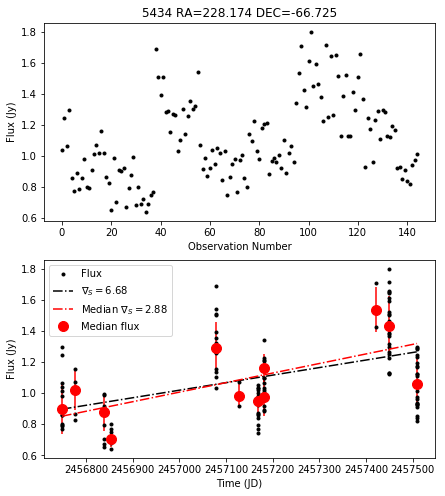

<Figure size 720x864 with 0 Axes>

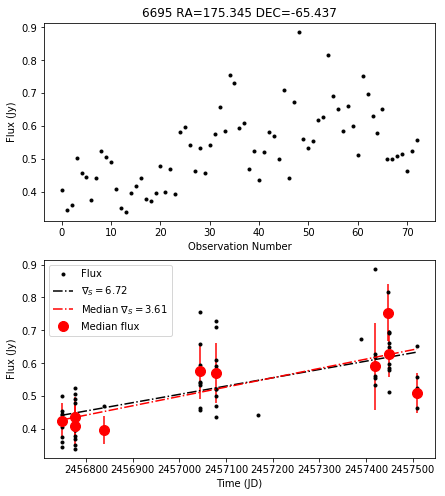

<Figure size 720x864 with 0 Axes>

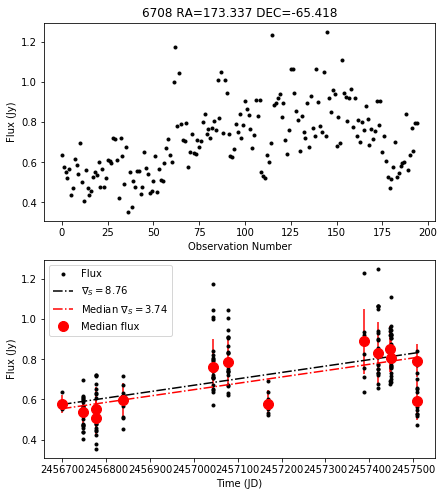

<Figure size 720x864 with 0 Axes>

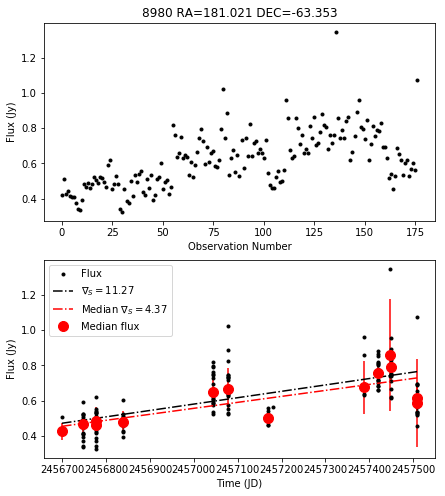

<Figure size 720x864 with 0 Axes>

<Figure size 720x864 with 0 Axes>

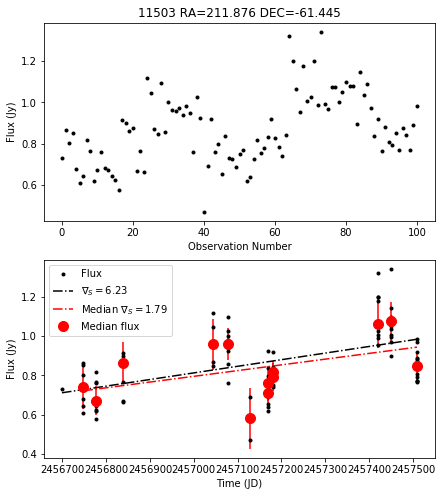

<Figure size 720x864 with 0 Axes>

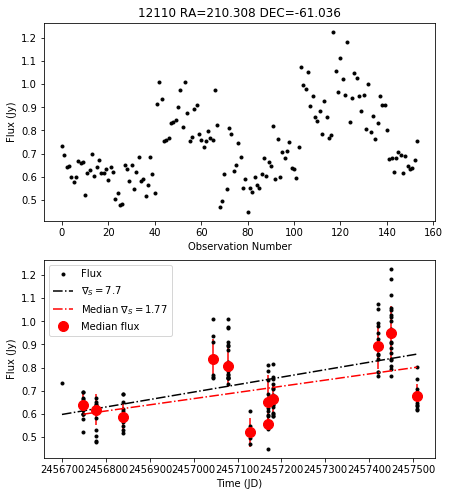

<Figure size 720x864 with 0 Axes>

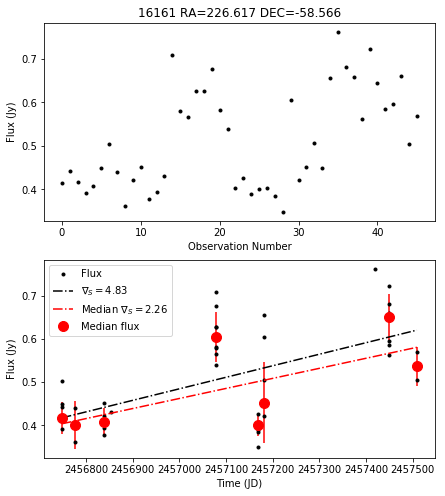

<Figure size 720x864 with 0 Axes>

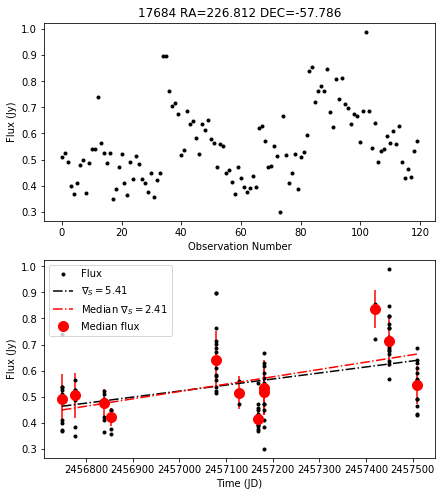

<Figure size 720x864 with 0 Axes>

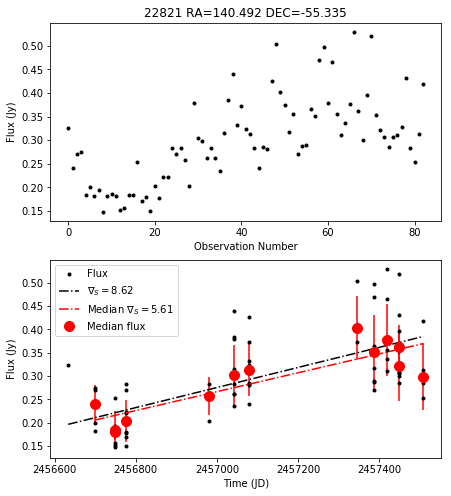

<Figure size 720x864 with 0 Axes>

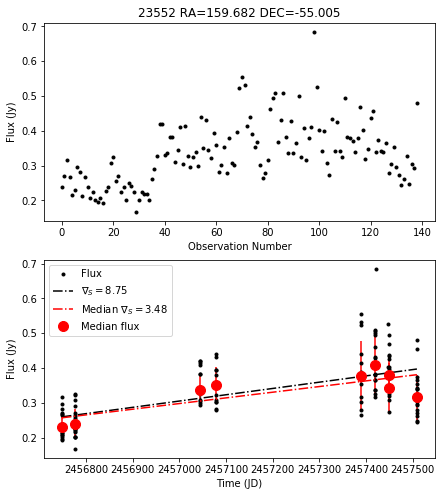

<Figure size 720x864 with 0 Axes>

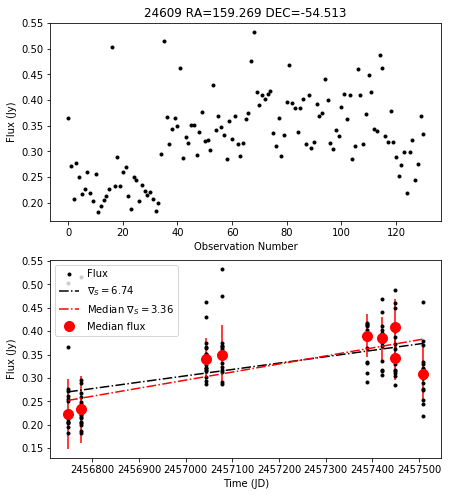

<Figure size 720x864 with 0 Axes>

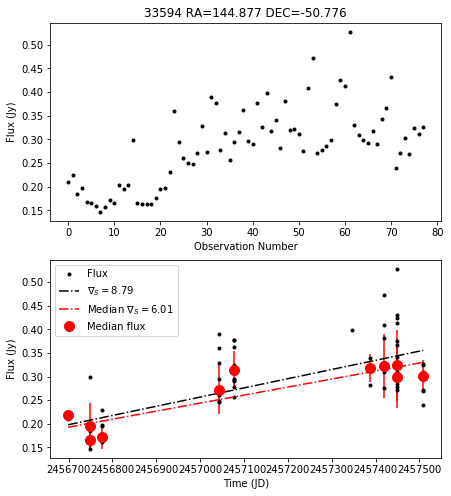

<Figure size 720x864 with 0 Axes>

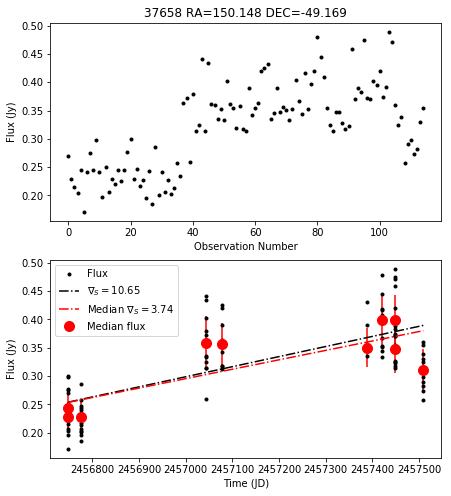

<Figure size 720x864 with 0 Axes>

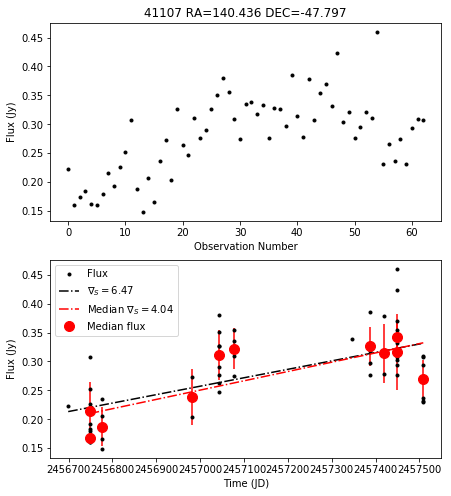

<Figure size 720x864 with 0 Axes>

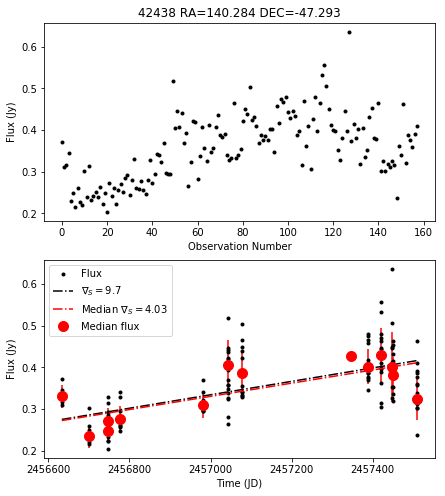

<Figure size 720x864 with 0 Axes>

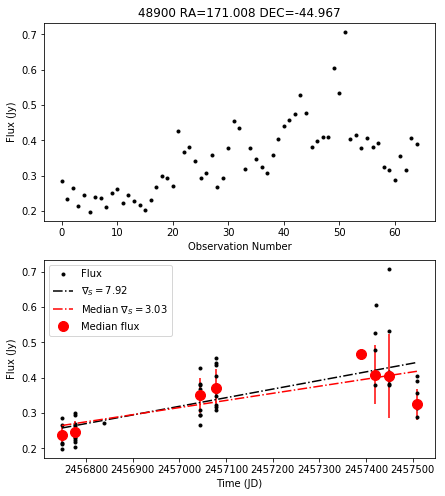

<Figure size 720x864 with 0 Axes>

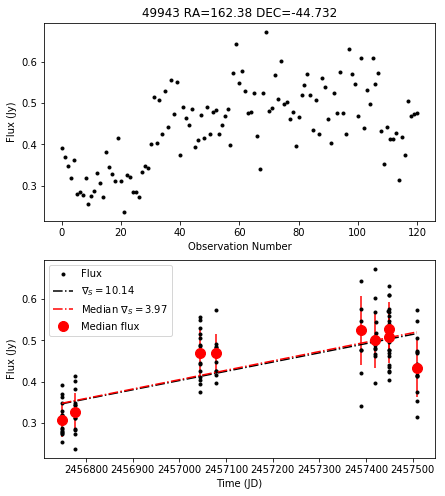

<Figure size 720x864 with 0 Axes>

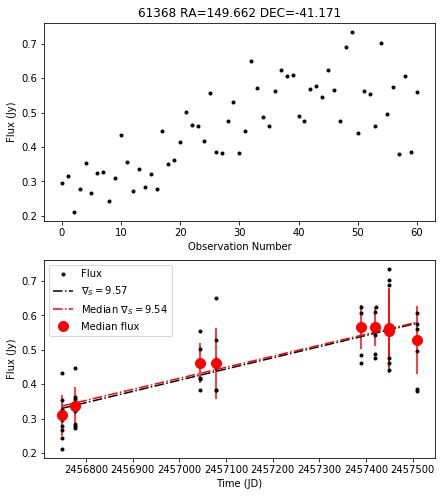

<Figure size 720x864 with 0 Axes>

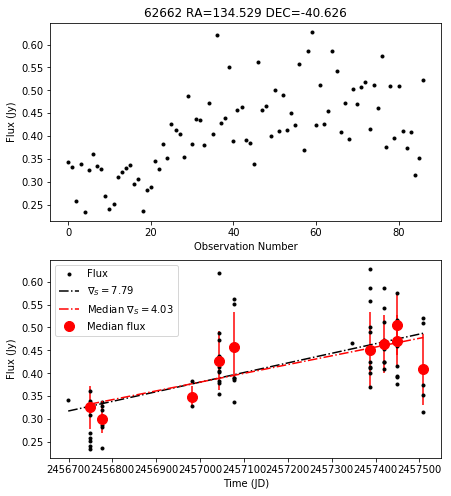

<Figure size 720x864 with 0 Axes>

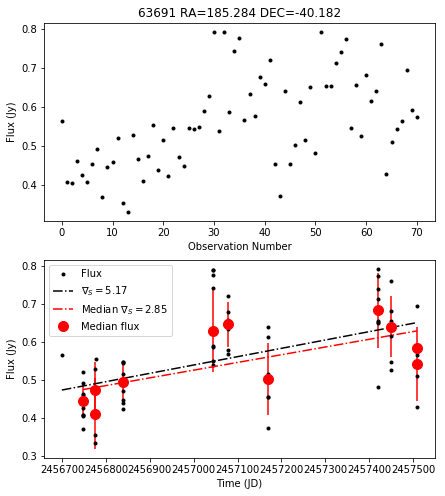

<Figure size 720x864 with 0 Axes>

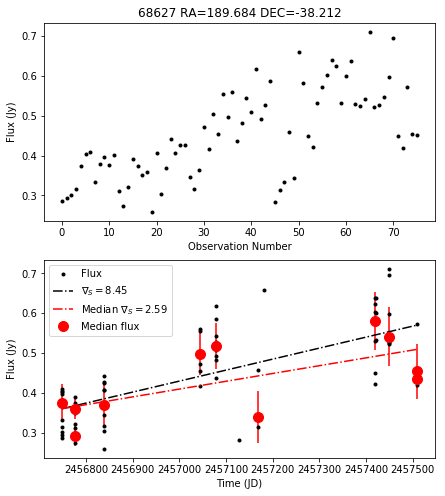

<Figure size 720x864 with 0 Axes>

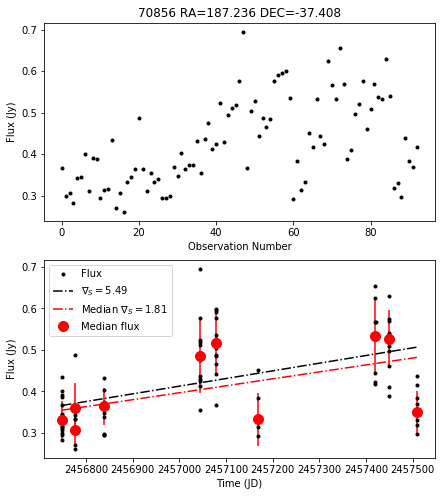

<Figure size 720x864 with 0 Axes>

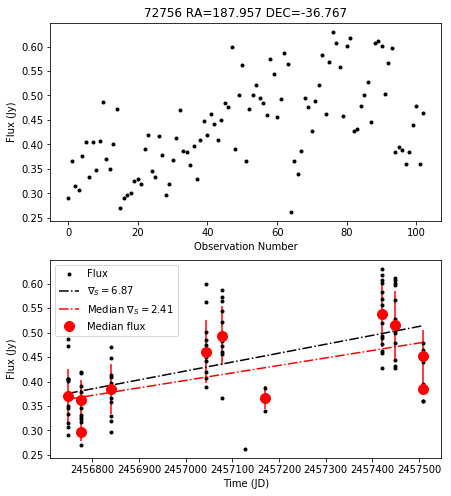

<Figure size 720x864 with 0 Axes>

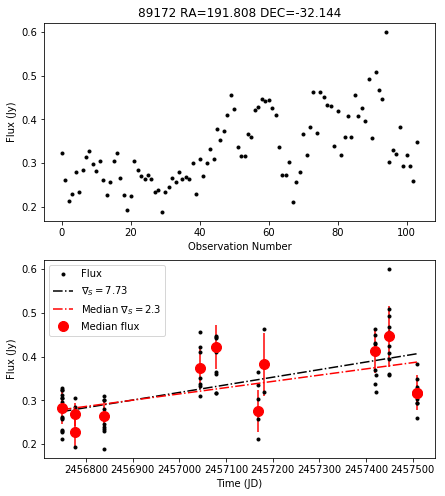

<Figure size 720x864 with 0 Axes>

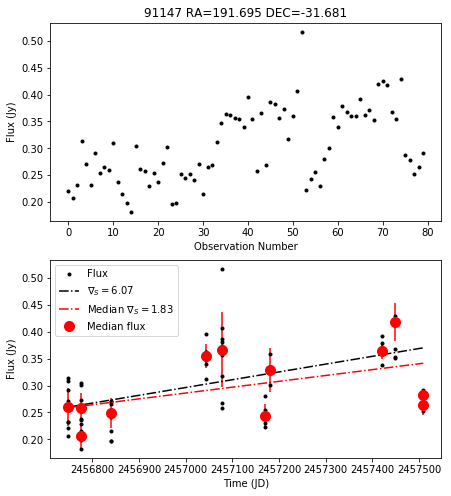

<Figure size 720x864 with 0 Axes>

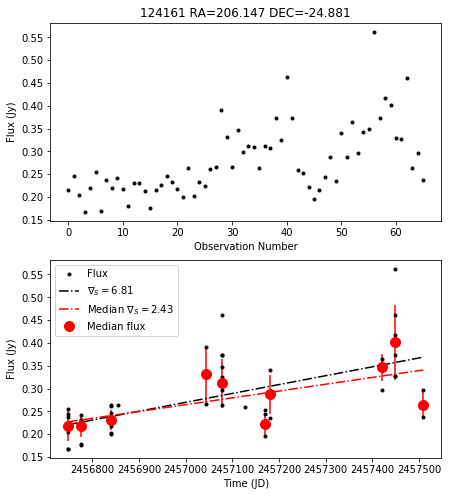

<Figure size 720x864 with 0 Axes>

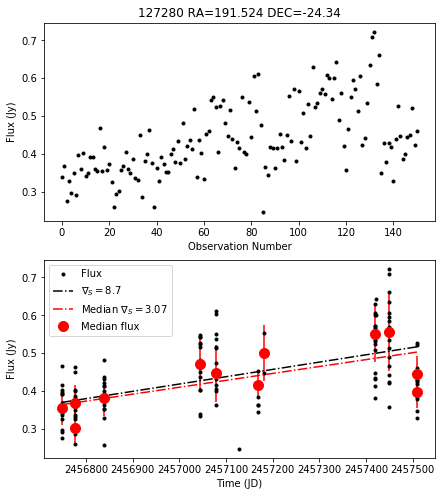

<Figure size 720x864 with 0 Axes>

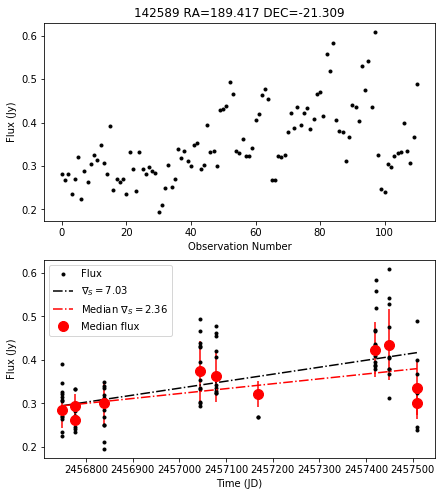

<Figure size 720x864 with 0 Axes>

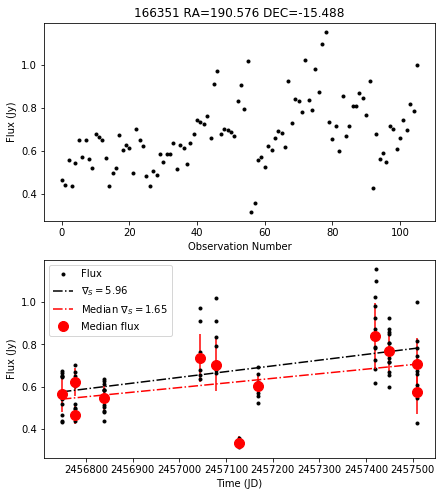

<Figure size 720x864 with 0 Axes>

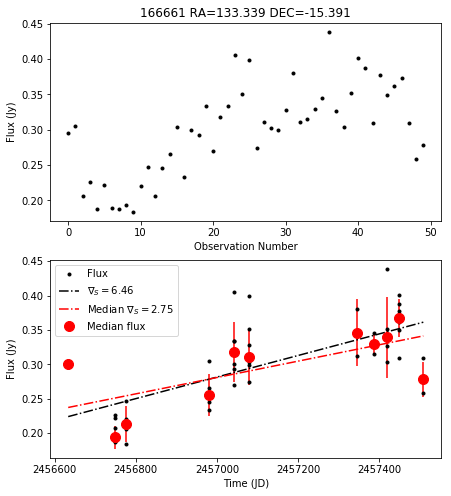

<Figure size 720x864 with 0 Axes>

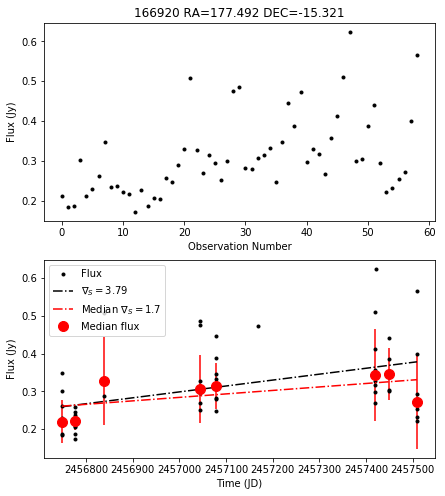

<Figure size 720x864 with 0 Axes>

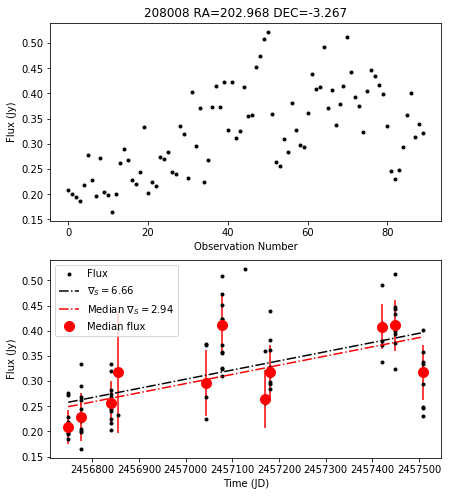

<Figure size 720x864 with 0 Axes>

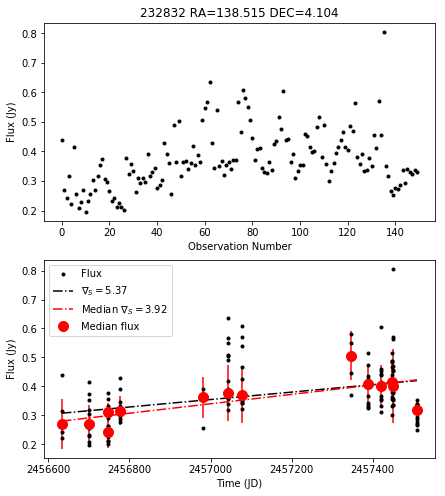

<Figure size 720x864 with 0 Axes>

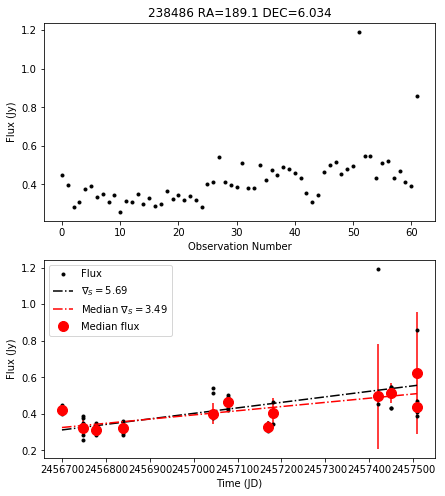

<Figure size 720x864 with 0 Axes>

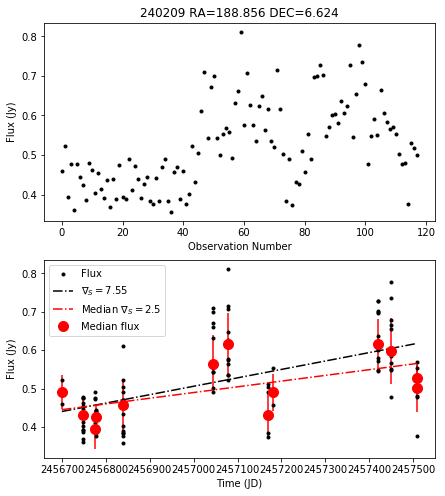

<Figure size 720x864 with 0 Axes>

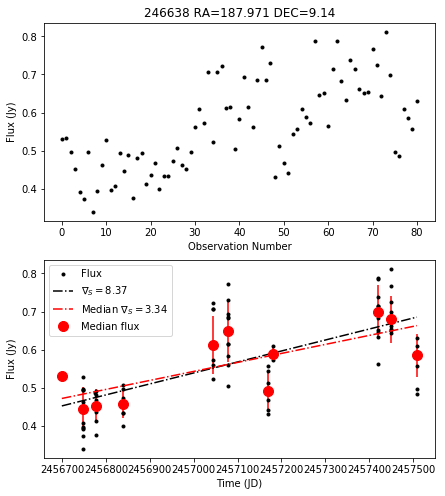

<Figure size 720x864 with 0 Axes>

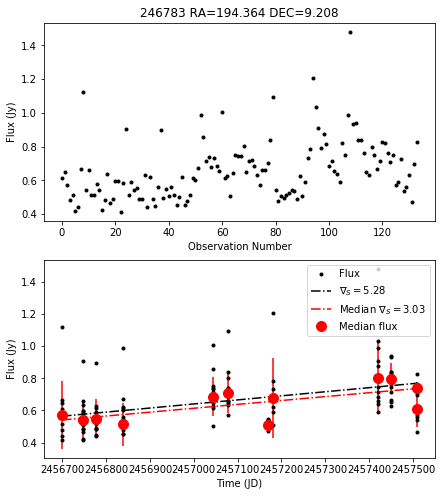

<Figure size 720x864 with 0 Axes>

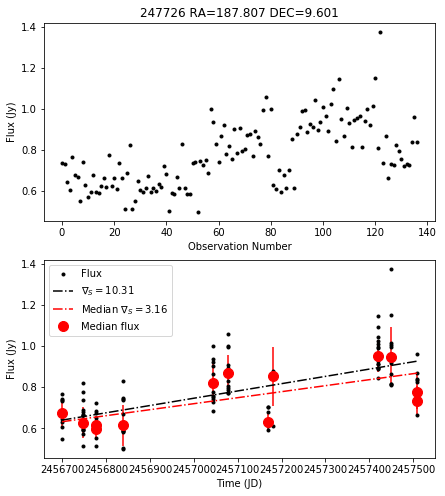

<Figure size 720x864 with 0 Axes>

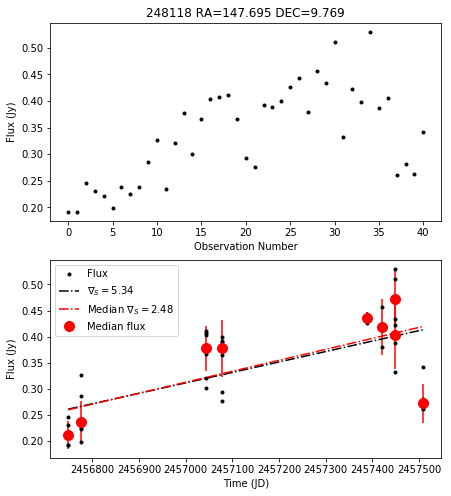

<Figure size 720x864 with 0 Axes>

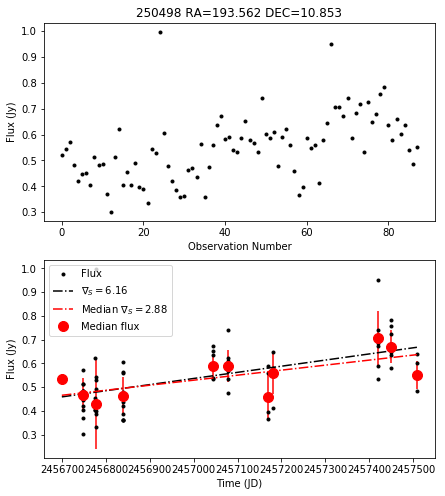

<Figure size 720x864 with 0 Axes>

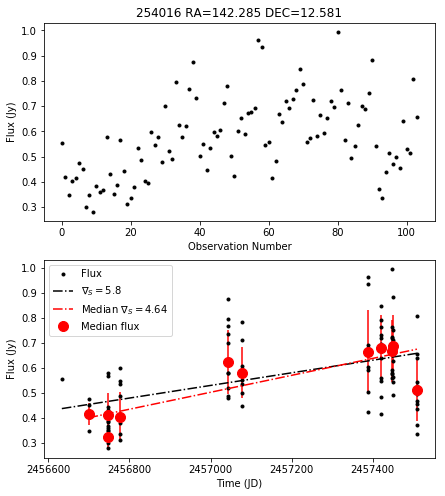

<Figure size 720x864 with 0 Axes>

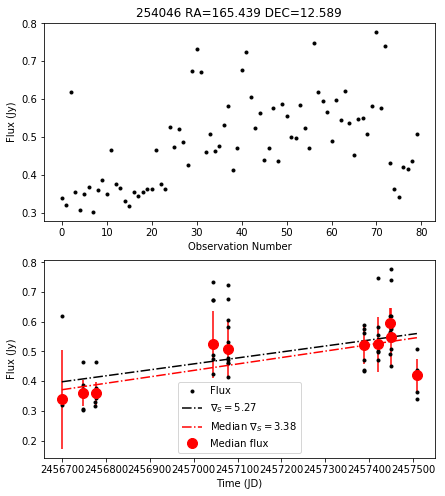

<Figure size 720x864 with 0 Axes>

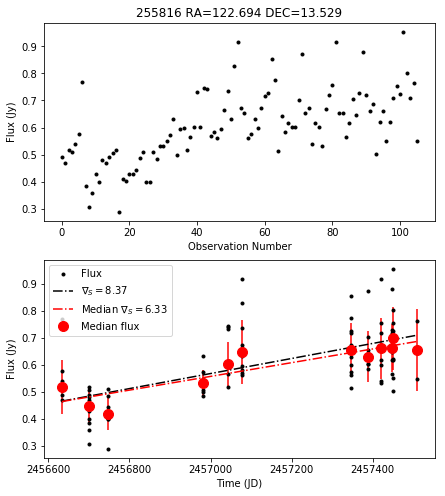

<Figure size 720x864 with 0 Axes>

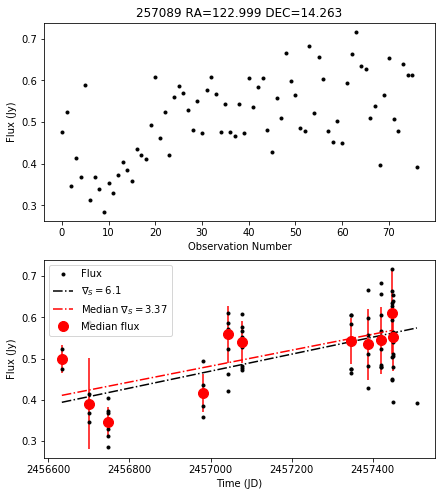

<Figure size 720x864 with 0 Axes>

In [35]:
# Make plots of those sources. 
show_results(interesting)

correlated = interesting

pd.set_option('display.max_colwidth', -1)
HTML(interesting.to_html(escape=False))

# Bell et al. 2018 Sample. 

In [91]:
avg_sig_cut = 3.0
avg_flux_cut = 0.0
avg_Mod_cut = 5.0
Mod_cut = 0.0
F = 0
kruskal_p_value = 1.0
anova_p_value = 1.0
corr_cut = 0.4

interesting = stats[ ( ( stats.avg_sig.abs() ) > avg_sig_cut )             
             & (stats.mean_raw_peak_flux > avg_flux_cut)
             & (stats.avg_Mod > avg_Mod_cut) 
             & (stats.Mod > Mod_cut)
             & (stats.p_k < kruskal_p_value)   
             & (stats.p_a < anova_p_value)
             & (stats.l_corr_1 < corr_cut) 
             & (stats.l_corr_2 < corr_cut)
             & (stats.l_corr_3 < corr_cut)
             & (stats.l_corr_4 < corr_cut)
             & (stats.l_corr_5 < corr_cut)]

len(interesting) # How many objects we have in our cut.

246

In [83]:
# Make plots of those sources. 
show_results(interesting)

pd.set_option('display.max_colwidth', -1)
HTML(interesting.to_html(escape=False))

,Thumb,LCs,Avg LC,URL,candidate,index,source_id,ra,dec,mean_raw_peak_flux,std_raw_peak_flux,Mod,length,F_a,p_a,F_k,p_k,sig,grad,fit_error,y_int,avg_sig,avg_grad,avg_fit_error,avg_y_int,avg_std,avg_median,avg_Mod,x_corr_1,x_corr_2,x_corr_3,x_corr_4,x_corr_5,l_corr_1,l_corr_2,l_corr_3,l_corr_4,l_corr_5
1513,,,,Simbad Link,PMN J0820-6438,1513,7510,125.121018,-64.643418,0.785406,0.115262,14.675529,270,1.536317,8.735673e-02,47.792412,5.119995e-05,-3.784659,-0.000082,0.000022,202.451767,-5.303733,-0.000120,0.000023,295.044629,0.049585,0.773903,6.407175,-0.282237,-0.170600,-0.542342,-0.189224,-0.390306,-0.266525,0.054818,-0.545708,0.003794,-0.378714
6129,,,,Simbad Link,No object found,6129,22186,37.960557,-55.634732,0.934286,0.077252,8.268597,258,22.041758,1.133299e-32,145.435883,4.769850e-25,-12.045809,-0.000156,0.000013,385.137224,-5.213049,-0.000149,0.000029,367.798271,0.054477,0.923010,5.902083,0.024630,0.226302,0.057282,-0.003511,0.138919,0.054584,0.263920,0.056020,0.050782,0.116870
7739,,,,Simbad Link,PKS J0316-5311,7739,27759,49.033735,-53.195724,0.867071,0.066083,7.621427,249,15.275118,5.525364e-26,137.379138,2.352700e-22,12.449702,0.000137,0.000011,-334.722691,8.620393,0.000138,0.000016,-339.231593,0.044119,0.877252,5.029257,0.023333,0.178271,0.019852,-0.221989,0.080614,0.030934,0.270287,0.156792,-0.192707,0.077222
13552,,,,Simbad Link,MRC 2236-454,13552,47681,339.891330,-45.236974,1.583500,0.157211,9.928077,163,25.612187,2.849211e-29,60.532589,7.382134e-09,10.171805,0.000435,0.000043,-1067.235077,5.120520,0.000490,0.000096,-1202.672265,0.155116,1.539064,10.078566,-0.092176,0.046518,-0.087767,-0.244374,0.010948,-0.067022,0.065902,-0.104025,-0.328564,-0.049306
15955,,,,Simbad Link,PMN J1125-4203,15955,59118,171.277061,-42.059630,0.909008,0.099350,10.929461,115,1.712324,8.075557e-02,29.114069,2.179252e-03,-3.617607,-0.000109,0.000030,267.693897,-5.473332,-0.000147,0.000027,363.127969,0.052623,0.905462,5.811737,-0.171799,-0.336523,0.086459,-0.327848,-0.339046,0.090713,-0.249300,0.111567,-0.151144,-0.258793
17091,,,,Simbad Link,UCAC2 14599882,17091,63075,164.392206,-40.435210,0.961736,0.072410,7.529094,128,13.410316,1.079905e-13,66.119685,2.897430e-11,-10.071778,-0.000165,0.000016,406.895658,-8.104262,-0.000158,0.000020,390.027600,0.050180,0.957992,5.238083,-0.270325,-0.388734,-0.263320,-0.382753,0.161367,-0.255652,-0.393883,-0.210557,-0.440139,0.153605
18137,,,,Simbad Link,PMN J0640-3851,18137,66901,100.106636,-38.856283,1.113403,0.093809,8.425428,123,17.480156,2.257092e-20,70.613630,2.458546e-10,-12.051472,-0.000220,0.000018,541.459838,-6.057083,-0.000217,0.000036,533.369936,0.079129,1.119427,7.068692,0.230439,-0.276702,-0.158987,-0.188471,-0.190164,0.197376,-0.210283,-0.105788,-0.072493,-0.032451
18719,,,,Simbad Link,No object found,18719,68861,310.714909,-38.128272,0.776260,0.084351,10.866384,91,2.352074,2.058781e-02,16.820756,5.159804e-02,-2.460513,-0.000090,0.000036,220.867744,-5.155577,-0.000157,0.000031,387.512600,0.049925,0.790814,6.313097,-0.144377,-0.133778,0.175215,0.203948,0.222625,-0.083332,-0.144068,0.123977,0.181993,0.177678
22305,,,,Simbad Link,PKS 2051-341,22305,82643,313.615397,-33.920099,0.487002,0.076506,15.709578,115,13.642477,9.650364e-16,68.917129,1.961412e-10,-11.049245,-0.000234,0.000021,576.644372,-7.149183,-0.000250,0.000035,613.734982,0.081713,0.510441,16.008408,0.145104,0.303139,0.245188,0.059319,0.301549,0.230479,0.327879,0.205256,0.108161,0.300901
22481,,,,Simbad Link,PKS 2039-339,22481,83332,310.549383,-33.720695,0.392841,0.046642,11.872961,111,1.535220,1.308945e-01,14.591094,2.019923e-01,-2.807665,-0.000050,0.000018,122.505758,-5.498000,-0.000083,0.000015,203.711021,0.028442,0.400056,7.109424,0.274603,0.114447,0.159374,-0.029396,0.187400,0.287295,0.121152,0.030866,-0.066645,0.235811


In [19]:
ras = []
decs = []
names = []
for file in glob.glob("/Users/134393/Work/MWATS_var_paper/FINAL_LCS/variables_gte_mod_3_gte_sig_3/GLEAM*.txt"):
    name = file.split('sig_3/')[1]
    name = file.split('.txt')[0]
    names.append(name)   
    source = json.load(open(file))
    ra = float(source['ra'])
    ras.append(ra)
    dec = float(source['dec'])
    decs.append(dec)

In [46]:
# Get the source ids
search_box = 0.5
bell_ids = []
for i in range(len(ras)-1):
    id = stats[stats.ra < (ras[i]+search_box) ]
    id = id[id.ra > (ras[i]-search_box) ]
    id = id[id.dec < (decs[i]+search_box) ]
    id = id[id.dec > (decs[i]-search_box) ]
    id = id[id.mean_raw_peak_flux > 3.0]
    #print(id.source_id.values[0])
    bell_ids.append(id.source_id.values[0])

In [87]:
bell_sources = stats[stats['source_id'].isin(bell_ids)]

In [88]:
show_results(bell_sources)
pd.set_option('display.max_colwidth', -1)
HTML(bell_sources.to_html(escape=False))

,Thumb,LCs,Avg LC,URL,candidate,index,source_id,ra,dec,mean_raw_peak_flux,std_raw_peak_flux,Mod,length,F_a,p_a,F_k,p_k,sig,grad,fit_error,y_int,avg_sig,avg_grad,avg_fit_error,avg_y_int,avg_std,avg_median,avg_Mod,x_corr_1,x_corr_2,x_corr_3,x_corr_4,x_corr_5,l_corr_1,l_corr_2,l_corr_3,l_corr_4,l_corr_5
8189,,,,Simbad Link,PKS 0409-526,8189,29267,62.593003,-52.546047,3.535674,0.222736,6.299685,245,29.184968,5.883138e-49,170.260886,8.049491e-27,-10.840015,-0.000411,0.000038,1013.693841,-4.970494,-0.000573,0.000115,1410.256141,0.234739,3.437566,6.828645,-0.018103,0.148288,0.354227,0.084174,0.207488,-0.080650,0.193731,0.338787,0.113008,0.155905
12979,,,,Simbad Link,QSO B0524-460,12979,45783,81.381014,-45.964412,3.482846,0.161309,4.631530,208,16.767056,1.909939e-28,131.717824,2.976230e-20,13.759871,0.000343,0.000025,-838.490591,7.421744,0.000352,0.000047,-861.961061,0.131773,3.496575,3.768639,0.297472,0.125033,0.241160,0.253538,0.359184,0.241817,0.118571,0.238453,0.215229,0.141805
16139,,,,Simbad Link,ATPMN J100557.3-414852,16139,59733,151.489094,-41.813898,3.231189,0.132492,4.100417,113,9.298270,3.206751e-10,44.437613,1.172073e-06,-6.278756,-0.000224,0.000036,554.552379,-3.082239,-0.000301,0.000098,742.460572,0.133209,3.256893,4.090071,-0.381053,-0.587296,0.396663,-0.355801,0.058986,-0.340779,-0.498964,0.490369,-0.271476,-0.022633
17389,,,,Simbad Link,PKS J1428-3958,17389,64161,217.180022,-39.979392,4.041959,0.220098,5.445327,94,1.540088,1.331139e-01,8.751070,6.448575e-01,0.467354,0.000037,0.000080,-87.701732,0.517432,0.000112,0.000217,-271.600166,0.182148,4.034315,4.514965,-0.007767,-0.192041,0.013709,0.037094,-0.008960,-0.009789,-0.010363,0.102909,-0.084638,-0.021635
17874,,,,Simbad Link,ATPMN J225459.9-391301,17874,65988,343.749699,-39.217082,5.381797,0.331613,6.161749,90,3.876557,1.769914e-04,31.939533,7.799554e-04,3.898431,0.000599,0.000154,-1465.516432,2.703843,0.000564,0.000209,-1381.121965,0.233825,5.377835,4.347946,-0.076048,-0.278138,0.000519,-0.043248,-0.224098,-0.068101,-0.366760,-0.030160,-0.068673,-0.294339
19668,,,,Simbad Link,QSO B2244-372,19668,72134,341.765870,-36.960890,4.150850,0.229660,5.532847,110,4.914958,4.973581e-06,39.901921,3.718348e-05,3.328545,0.000317,0.000095,-774.679784,2.235681,0.000314,0.000140,-766.357991,0.146276,4.129795,3.541972,0.331022,-0.241590,-0.141431,-0.064942,-0.230456,0.324619,-0.267548,-0.212468,-0.093886,-0.337382
21251,,,,Simbad Link,ICRF J115421.7-350529,21251,78406,178.590894,-35.090282,6.610260,0.576777,8.725487,130,54.247846,5.109638e-42,104.536018,7.161941e-17,-14.975420,-0.001571,0.000105,3866.298600,-4.410232,-0.001588,0.000360,3908.059970,0.578771,6.588252,8.784897,-0.395422,-0.180564,-0.368552,0.327773,0.165966,-0.388894,-0.323658,-0.328546,0.303692,-0.003049
27833,,,,Simbad Link,PKS 2216-28,27833,109103,334.927995,-27.940352,8.221449,0.377053,4.586217,135,6.479410,7.890851e-09,49.243997,1.895858e-06,6.664101,0.000889,0.000133,-2176.232230,5.614190,0.001145,0.000204,-2804.140950,0.384448,8.142529,4.721475,0.465894,0.223595,-0.269984,0.634150,-0.070153,0.383967,0.236942,-0.278578,0.634511,-0.068212
42702,,,,Simbad Link,PKS 0507-122,42702,176330,77.548079,-12.178382,5.255631,0.238183,4.531958,101,1.771192,6.546388e-02,19.816120,7.064529e-02,-2.081112,-0.000160,0.000077,398.916994,-1.380075,-0.000103,0.000075,259.162524,0.075876,5.230126,1.450757,0.015747,0.434983,-0.095599,0.144237,-0.085325,-0.001583,0.390666,-0.050215,0.298377,-0.008488
52884,,,,Simbad Link,4C -02.79,52884,211091,301.534373,-2.392875,4.220496,0.236716,5.608732,129,6.838656,6.966151e-08,59.353804,1.785510e-09,-6.764379,-0.000537,0.000079,1323.092612,-4.151345,-0.000468,0.000113,1153.995361,0.127767,4.220084,3.027597,0.149367,0.049110,-0.136178,0.289444,0.276235,0.120952,0.055954,-0.169867,0.304235,0.101722


In [92]:
survived_filter = interesting[interesting['source_id'].isin(bell_sources.source_id)]

In [93]:
show_results(survived_filter)
pd.set_option('display.max_colwidth', -1)
HTML(survived_filter.to_html(escape=False))

,Thumb,LCs,Avg LC,URL,candidate,index,source_id,ra,dec,mean_raw_peak_flux,std_raw_peak_flux,Mod,length,F_a,p_a,F_k,p_k,sig,grad,fit_error,y_int,avg_sig,avg_grad,avg_fit_error,avg_y_int,avg_std,avg_median,avg_Mod,x_corr_1,x_corr_2,x_corr_3,x_corr_4,x_corr_5,l_corr_1,l_corr_2,l_corr_3,l_corr_4,l_corr_5
8189,,,,Simbad Link,PKS 0409-526,8189,29267,62.593003,-52.546047,3.535674,0.222736,6.299685,245,29.184968,5.883138e-49,170.260886,8.049491e-27,-10.840015,-0.000411,0.000038,1013.693841,-4.970494,-0.000573,0.000115,1410.256141,0.234739,3.437566,6.828645,-0.018103,0.148288,0.354227,0.084174,0.207488,-0.080650,0.193731,0.338787,0.113008,0.155905
21251,,,,Simbad Link,ICRF J115421.7-350529,21251,78406,178.590894,-35.090282,6.610260,0.576777,8.725487,130,54.247846,5.109638e-42,104.536018,7.161941e-17,-14.975420,-0.001571,0.000105,3866.298600,-4.410232,-0.001588,0.000360,3908.059970,0.578771,6.588252,8.784897,-0.395422,-0.180564,-0.368552,0.327773,0.165966,-0.388894,-0.323658,-0.328546,0.303692,-0.003049
61252,,,,Simbad Link,4C 05.14,61252,237262,50.834636,5.568597,4.865141,0.335575,6.897540,144,21.650735,1.369320e-25,104.820371,6.295988e-17,16.309441,0.000881,0.000054,-2158.510481,14.973646,0.000935,0.000062,-2292.255442,0.294770,4.914282,5.998233,-0.022153,-0.119552,-0.110281,0.125966,-0.263695,-0.005182,0.081248,-0.149423,0.313887,-0.248330


# Export the data

In [107]:
out_kruskal = kruskal

In [108]:
out_kruskal = out_kruskal.drop(columns=['Thumb', 'LCs', 'Avg LC', 'URL', 'std_raw_peak_flux', 'length', 'F_a', 'F_k', 'avg_y_int', 'avg_fit_error', 'avg_median', 'fit_error','Mod','index','avg_std','grad','avg_grad','sig','y_int'])
out_kruskal['p_k'] = np.log10(out_kruskal['p_k'])
out_kruskal['p_a'] = np.log10(out_kruskal['p_a'])
out_kruskal['l_corr'] = out_kruskal[['l_corr_1','l_corr_2','l_corr_3', 'l_corr_4','l_corr_5']].mean(axis=1)
out_kruskal['x_corr'] = out_kruskal[['x_corr_1','x_corr_2','x_corr_3', 'x_corr_4','x_corr_5']].mean(axis=1)
out_kruskal = out_kruskal.drop(columns=['x_corr_1','x_corr_2','x_corr_3', 'x_corr_4','x_corr_5','l_corr_1','l_corr_2','l_corr_3', 'l_corr_4','l_corr_5'])
out_kruskal = out_kruskal.round(2)

In [110]:
with open('kruskal.tex', 'w') as tf:
     tf.write(out_kruskal.to_latex(index=False))

In [109]:
out_kruskal

,candidate,source_id,ra,dec,mean_raw_peak_flux,p_a,p_k,avg_sig,avg_Mod,l_corr,x_corr
1450,1RXS J025716.2-644858,7311,44.32,-64.83,0.51,-38.29,-15.04,0.59,11.79,0.25,0.19
1455,CPD-65 239,7323,51.53,-64.81,0.50,-30.52,-14.86,0.93,9.80,0.19,0.13
2096,No object found,9109,55.58,-63.24,0.64,-19.61,-15.10,-3.63,7.35,0.10,0.07
2172,TYC 8871-627-1,9310,60.84,-63.09,0.54,-24.75,-15.03,2.12,12.42,0.32,0.20
3867,TYC 8579-461-1,14473,124.26,-59.55,0.36,-27.39,-17.84,2.05,17.91,0.09,0.04
5298,ICRF J005846.5-565911,19305,14.70,-56.98,0.43,-32.60,-23.33,-0.37,9.66,0.30,0.14
5511,PMN J0330-5637,20038,52.54,-56.63,0.76,-20.44,-20.79,-0.03,5.13,0.28,0.18
5653,PMN J0319-5622,20559,49.90,-56.37,0.96,-36.57,-22.67,-3.39,5.51,-0.09,-0.08
5947,PMN J0315-5551,21598,48.83,-55.85,0.45,-23.15,-18.06,-1.90,8.71,0.19,0.09
6129,No object found,22186,37.96,-55.63,0.93,-31.95,-24.32,-5.21,5.90,0.11,0.09


# Make the final LCs for the paper

In [106]:
def jd_to_datetime(jd):
    year, month, day = jd_to_date(jd)
    frac_days,day = math.modf(day)
    day = int(day)
    hour,min,sec,micro = days_to_hmsm(frac_days)
    return datetime.datetime(year,month,day,hour,min,sec,micro)

In [109]:
def jd_to_date(jd):
    jd = jd + 0.5
    F, I = math.modf(jd)
    I = int(I)
    A = math.trunc((I - 1867216.25)/36524.25)
    if I > 2299160:
        B = I + 1 + A - math.trunc(A / 4.)
    else:
        B = I
    C = B + 1524
    D = math.trunc((C - 122.1) / 365.25)
    E = math.trunc(365.25 * D)
    G = math.trunc((C - E) / 30.6001)
    day = C - E + F - math.trunc(30.6001 * G)
    if G < 13.5:
        month = G - 1
    else:
        month = G - 13
    if month > 2.5:
        year = D - 4716
    else:
        year = D - 4715
    return year, month, day

In [114]:
def days_to_hmsm(days):
    hours = days * 24.
    hours, hour = math.modf(hours)
    mins = hours * 60.
    mins, min = math.modf(mins)
    secs = mins * 60.
    secs, sec = math.modf(secs)
    micro = round(secs * 1.e6)
    return int(hour), int(min), int(sec), int(micro)

In [198]:
def re_plot(id):
        # s_time, s_flux, s_error, name, m, x
        raw = filtered_raw_data[filtered_raw_data.source_id == id]
        raw = raw.sort_values(by='jd')
        s_time = list(raw.jd)
        s_flux = list(raw.raw_peak_flux)
        s_error = list(raw.err_raw_peak_flux)
        s_time_2 = list(raw.time)
        #### Plot linear ######
        plt.figure(figsize=(3.0, 3.5))
        ax = plt.subplot(211)
        plt.errorbar(range(0, len(s_flux)), s_flux, s_error, marker='.', color='k', linestyle='None', capsize=0)
        for f in range(len(s_time)-1):
            if (s_time[f+1] - s_time[f]) > 10:
                plt.plot([f,f],[0, max(s_flux)*1.2], marker=None, color='0.6', linestyle=':', linewidth=2.0)
        plt.xlabel('Epoch Number')
        plt.ylabel('Flux Density (Jy)')
        plt.ylim(0, max(s_flux)*1.2)
        locator = plt.MaxNLocator(nbins=5)
        ax.yaxis.set_major_locator(locator)
        locator = plt.MaxNLocator(nbins=5)
        ax.xaxis.set_major_locator(locator)
        plt.title(str(id))
        ######## Plot in time  ########
        ax = plt.subplot(212)
        avg = filtered_raw_avg_data[filtered_raw_avg_data.source_id == id]
        plt.errorbar(avg.time, avg.median_flux, avg.std_flux, fmt='ko', label="Median flux", markersize=4)
        ts = []
        ys = []
        plt.xlabel('Date')
        plt.ylabel('Flux Density (Jy)')
        plt.gcf().autofmt_xdate()
        plt.ylim(0, max(avg.median_flux)*1.2)
        ##### Plot the average #####
        plt.subplots_adjust(hspace=0.1)
        plt.xticks(rotation=45)
        locator = plt.MaxNLocator(nbins=7)
        ax.xaxis.set_major_locator(locator)
        locator = plt.MaxNLocator(nbins=5)
        ax.yaxis.set_major_locator(locator)
        xmin, xmax = plt.gca().get_xlim()
        xrange = xmax - xmin
        xmargin = xrange * 0.05
        xmin = xmin - xmargin
        xmax = xmax + xmargin
        plt.gca().set_xlim(xmin, xmax)
        plt.tight_layout()
        #plt.savefig('LCS/'+str(id)+'.eps')
        #plt.savefig('LCS/pulsars/'+str(id)+'.eps')
        plt.savefig('LCS/kruskal/'+str(id)+'.eps')
        ###############################



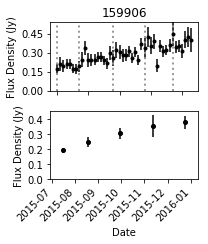

In [191]:
re_plot(159906)

/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/134393/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicit

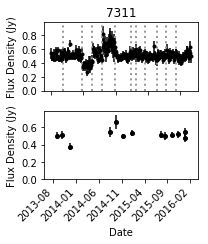

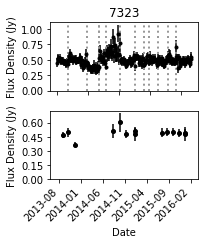

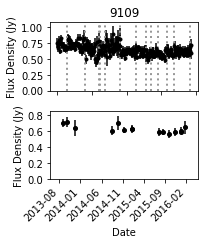

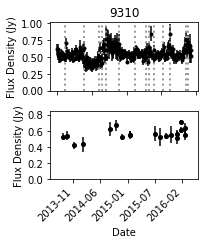

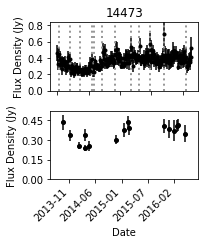

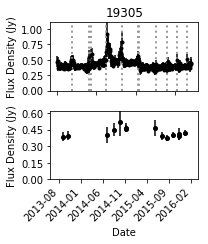

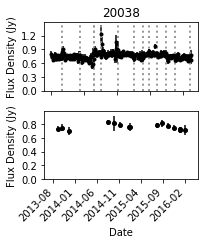

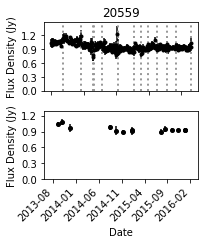

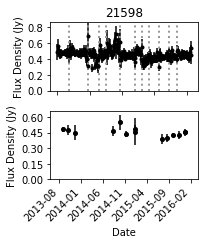

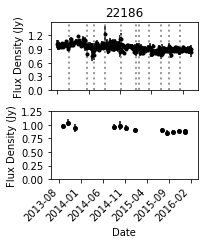

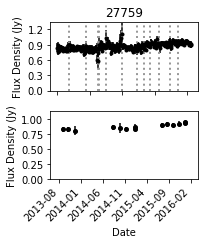

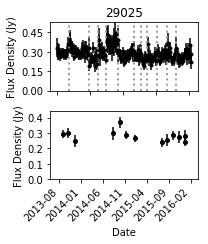

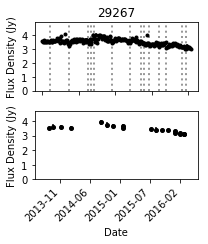

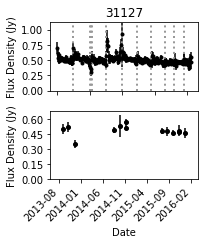

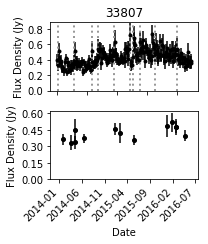

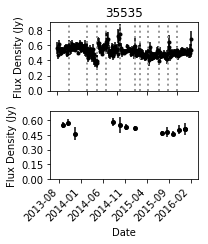

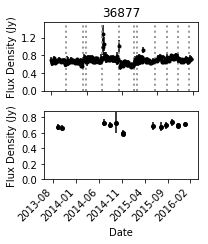

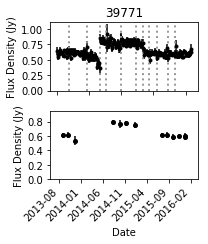

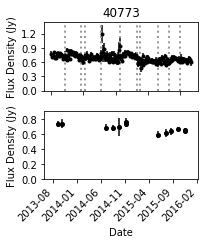

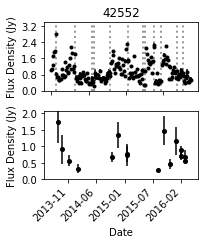

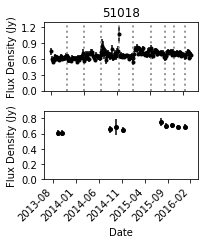

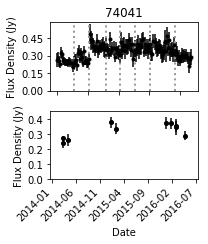

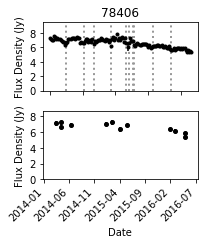

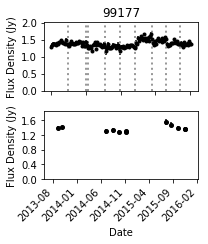

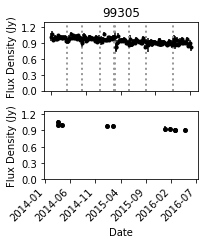

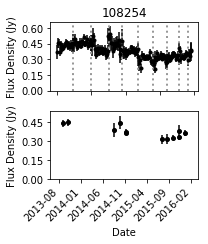

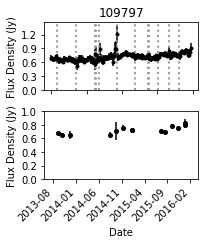

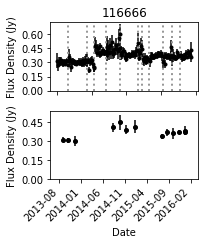

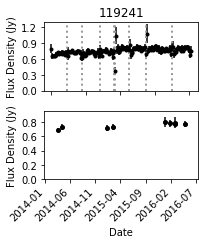

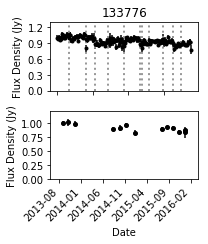

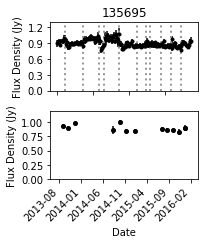

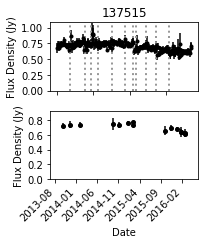

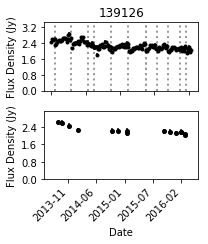

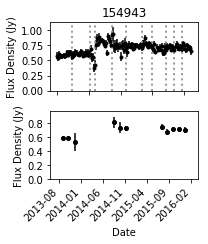

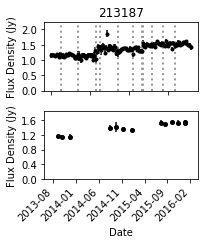

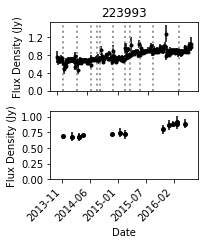

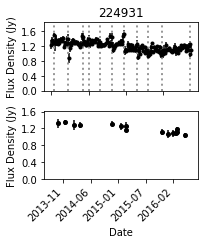

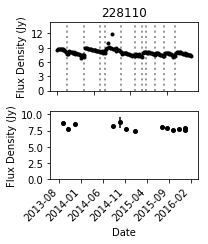

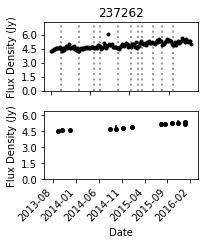

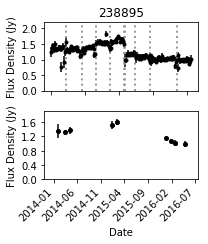

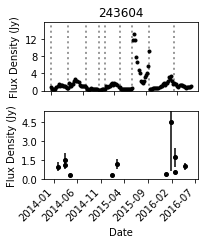

In [199]:
for i in kruskal.source_id:
    re_plot(i)

In [167]:
kruskal

NameError: name 'kruskal' is not defined